In [32]:
%pylab inline
import os.path as op
import sys
import os

import json

Populating the interactive namespace from numpy and matplotlib


## Import openslide

In [33]:
pth = op.expanduser(r"~\Downloads\openslide-win64-20171122\bin")
print(op.exists(pth))
# pth = op.expanduser(r"~\projects\scaffan\devel\knihovny")
# pth = op.expanduser(r"~\Miniconda3\envs\lisa36\Library\bin")
sys.path.insert(0, pth)
orig_PATH = os.environ["PATH"]
os.environ["PATH"] = pth + ";" + os.environ["PATH"]

True


In [34]:
# import numpy as np
import openslide as opsl

## Import lxml 

Doesnt work :-( #TODO

In [4]:

# os.environ["PATH"] = orig_PATH

In [5]:
#import lxml
#from lxml import etree


In [6]:
# dir(lxml)
# from lxml import etree 

# annotation_file = "e:data/scaffold/Hamamatsu/PIG-003_J-18-0165_HE.ndpi.ndpa"
# etree.parse(annotation_file)

In [7]:
# import lxml.etree

# Work with image data

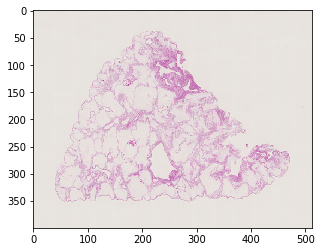

In [8]:
pth = op.expanduser(r"~\data\medical\orig\Scaffan-analysis\PIG-003_J-18-0165_HE.ndpi")
imsl = opsl.OpenSlide(pth)
imthumb = imsl.get_thumbnail((512, 512))

plt.imshow(imthumb)

## Histogram normalization

mean: 221.9782958984375, std: 14.000020204122187


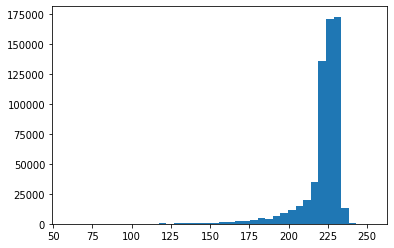

In [9]:
pixeldata = np.array(imthumb)[:,:,:].flatten()
plt.hist(pixeldata, bins=40)
mn = np.mean(pixeldata)
st = np.std(pixeldata)
print(f"mean: {mn}, std: {st}")


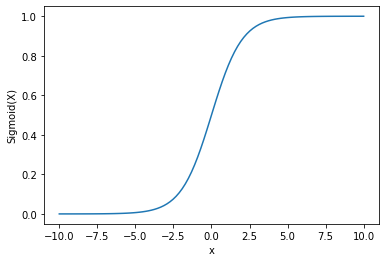

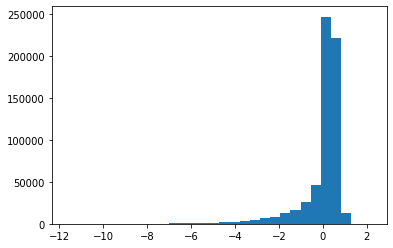

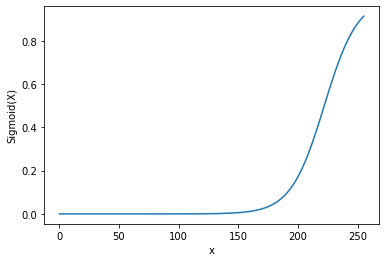

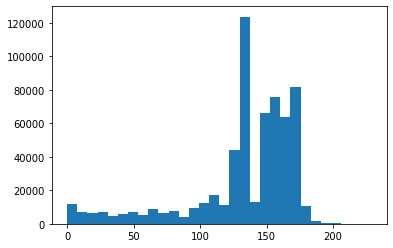

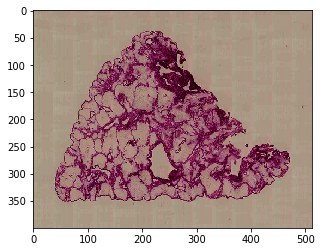

In [10]:

def sigmoidal(x):
    z = 1/(1 + np.exp(-x)) 
    return z
  
def make_norm(imdata, mn, st):
    imdata_norm = (imdata - mn) / st
    return imdata_norm 


def hist_mean_std_normalization(imdata):
    
    pixeldata = imdata.flatten()
#     plt.hist(pixeldata, bins=40)
    mn = np.mean(pixeldata)
    st = np.std(pixeldata)
    imdata_norm = make_norm(imdata, mn, st)
    return imdata_norm, mn, st
    
x = np.linspace(-10, 10, 100) 
z = sigmoidal(x)
plt.figure(1)
plt.plot(x, z) 
plt.xlabel("x") 
plt.ylabel("Sigmoid(X)") 

  
# plt.show() 
# plt.plot(x, z) 
# plt.xlabel("x") 
# plt.ylabel("Sigmoid(X)") 
  
# plt.show() 
imdata = np.array(imthumb)
imdata_norm, mn, st = hist_mean_std_normalization(imdata)
plt.figure(3)
plt.hist(imdata_norm.flatten(), bins=30)

x = np.linspace(0, 255, 100) 
z = sigmoidal(make_norm(x, mn, st))
plt.figure(2)
plt.plot(x, z) 
plt.xlabel("x") 
plt.ylabel("Sigmoid(X)") 


# from <-1,1> to <0,255>
imdata_norm_8bit = (sigmoidal(imdata_norm * 1.0) * 254)
plt.figure(4)
plt.hist(imdata_norm_8bit.flatten(), bins=30)
plt.figure(5)
plt.imshow(imdata_norm_8bit.astype(np.uint8))

175.0 234.0


(array([ 17066.,   4659.,   7167.,   9668.,  13627.,  18442.,  26601.,
         79573., 251387., 186210.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 10 Patch objects>)

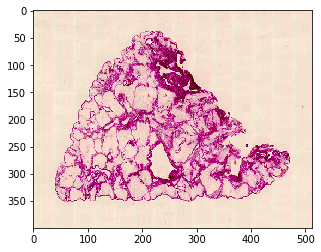

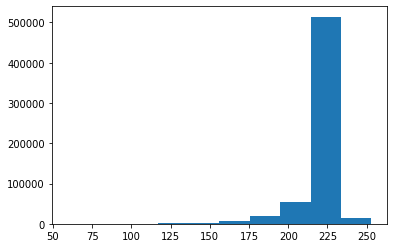

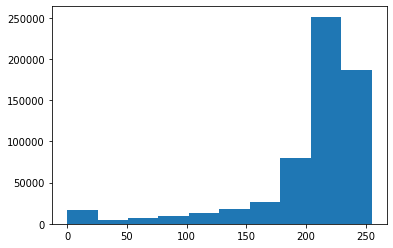

In [11]:
from skimage import exposure

# Contrast stretching
img = imdata
p2, p98 = np.percentile(img, (2, 98))
print(p2, p98)
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
plt.figure(1)
plt.imshow(img_rescale)
plt.figure(2)
plt.hist(img.ravel())
plt.figure(3)
plt.hist(img_rescale.ravel())

$$
y_0=kx_0 + q\\
y_1=kx_1 + q\\
$$
$$
y_0 - y1 = k (x_0 - x_1)\\
k = \frac{y_0 - y_1}{x_0 - x_1}\\
q = y_0 - kx_1
$$



100

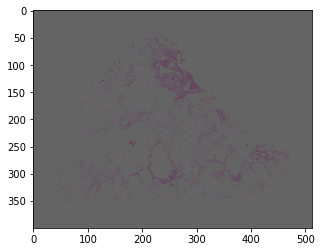

In [12]:
imout = exposure.rescale_intensity(img, in_range=(0,200), out_range=(30,100))
plt.imshow(imout)
np.max(imout)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-7.130769230769231 1.8230769230769237
6.40165499083365e-07 0.9745721579802262


(array([ 17066.,   7964.,   6778.,   6752.,   6273.,   4823.,   8180.,
          6111.,   6682.,   7451.,  13652.,  12187.,  17414.,  25974.,
        153255.,  79239.,  90420., 137881.,   6065.,    233.]),
 array([6.40165499e-07, 4.87292161e-02, 9.74577919e-02, 1.46186368e-01,
        1.94914944e-01, 2.43643520e-01, 2.92372096e-01, 3.41100671e-01,
        3.89829247e-01, 4.38557823e-01, 4.87286399e-01, 5.36014975e-01,
        5.84743551e-01, 6.33472127e-01, 6.82200703e-01, 7.30929279e-01,
        7.79657854e-01, 8.28386430e-01, 8.77115006e-01, 9.25843582e-01,
        9.74572158e-01]),
 <a list of 20 Patch objects>)

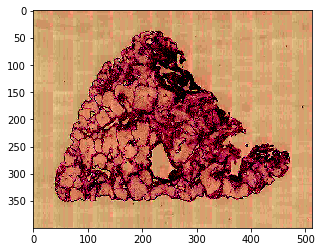

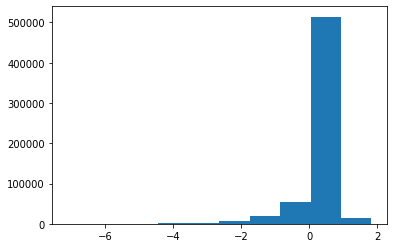

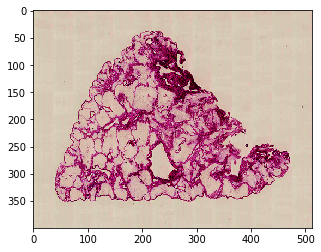

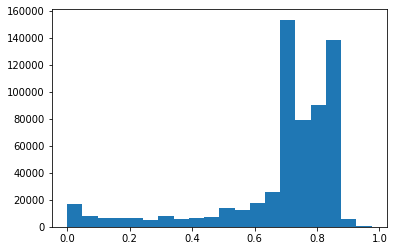

In [15]:
def rescale_intensity_no_limits(img, in_range, out_range=(-0.9, 0.9)):
    x0, x1 = in_range
    y0, y1 = out_range
    k = (y0 - y1) / (x0 - x1)
    q = y0 - k*x0
    
    img_out = k*img + q
    return img_out


def rescale_intensity_by_percentile(img, percentile_range=(5, 95), sig_range=(-0.9, 0.9), sig_slope=1):
    p2, p98 = np.percentile(img, percentile_range)
    imout = rescale_intensity_no_limits(img, in_range=(p2, p98), out_range=(-0.9, 0.9))
    return sigmoidal(img * sig_slope)

class RescaleIntensityPercentile():
    def __init__(self):
        self.percentile_range = None
        self.sig_range = None
        self.sig_slope = None
        self.input_dtype = None
        pass
    
    def calculate_parameters(self, img, percentile_range=(5, 95), sig_range=(-0.9, 0.9), sig_slope=1):
        self.percentile_range = percentile_range
        self.percentile_range_values = np.percentile(img, percentile_range)
        self.sig_range = sig_range
        self.sig_slope = sig_slope
        self.input_dtype = img.dtype
        
    def rescale_intensity(self, img):
        img_rescaled = rescale_intensity_no_limits(img, in_range=self.percentile_range_values, out_range=self.sig_range)
        imgout = sigmoidal(img_rescaled * self.sig_slope)
        if self.input_dtype == np.uint8:
            imgout = imgout * 255
        return imgout.astype(self.input_dtype)
        
        

p2, p98 = np.percentile(img, (5, 95))
imout = rescale_intensity_no_limits(img, in_range=(p2, p98), out_range=(-0.9, 0.9))

plt.figure(1)
plt.imshow(imout)
print(np.min(imout), np.max(imout))
plt.figure(2)
plt.hist(imout.ravel())

imout = sigmoidal(imout * 2)
plt.figure(3)
plt.imshow(imout)
print(np.min(imout), np.max(imout))
plt.figure(4)
plt.hist(imout.ravel(), bins=20)

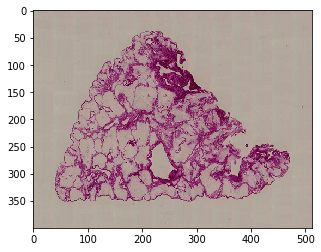

In [16]:
rescaler = RescaleIntensityPercentile()
rescaler.calculate_parameters(img)
img_rescaled = rescaler.rescale_intensity(img)
plt.imshow(img_rescaled)

In [17]:
img_rescaled

array([[[176, 168, 155],
        [176, 168, 155],
        [176, 168, 155],
        ...,
        [181, 168, 157],
        [181, 168, 157],
        [181, 168, 157]],

       [[176, 168, 155],
        [176, 168, 155],
        [176, 168, 155],
        ...,
        [181, 168, 157],
        [181, 168, 157],
        [181, 168, 157]],

       [[178, 171, 157],
        [178, 171, 157],
        [178, 171, 157],
        ...,
        [181, 168, 157],
        [181, 168, 157],
        [181, 168, 157]],

       ...,

       [[181, 173, 160],
        [181, 173, 160],
        [178, 171, 157],
        ...,
        [181, 168, 157],
        [181, 168, 157],
        [181, 168, 157]],

       [[178, 171, 157],
        [178, 171, 157],
        [178, 171, 157],
        ...,
        [178, 165, 155],
        [178, 165, 155],
        [178, 165, 155]],

       [[178, 171, 157],
        [178, 171, 157],
        [178, 171, 157],
        ...,
        [178, 165, 155],
        [178, 165, 155],
        [178, 165, 155]]

## Resolution

In [20]:
# resolution_unit = pm.get("tiff.ResolutionUnit")
# resolution_x= pm.get("tiff.XResolution")
# resolution_y= pm.get("tiff.YResolution")
# print("Resolution {}x{} pixels/{}".format(resolution_x, resolution_y, resolution_unit))

In [21]:
imsl.dimensions

(57344, 44800)

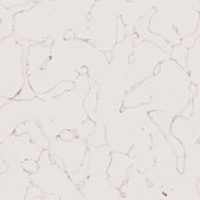

In [22]:
# one lobulus
kwargs_sample0 = dict(
    location = (10500, 21000),
    level = 2,
    size = (200, 200),
)
img0 = imsl.read_region(**kwargs_sample0)
img0

In [23]:
type(img0)
mode_to_bpp = {'1':1, 'L':8, 'P':8, 'RGB':24, 'RGBA':32, 'CMYK':32, 'YCbCr':24, 'I':32, 'F':32}

# data = Image.open('file.jpg')
bpp = mode_to_bpp[img0.mode]
img0.mode
# bpp

'RGBA'

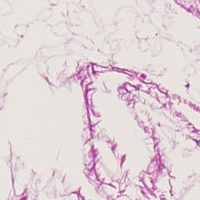

In [24]:
# one lobulus
kwargs_sample1 = dict(
    location = (13000, 15000),
    level = 2,
    size = (200, 200),
)
img0 = imsl.read_region(**kwargs_sample1)
img0

dtype('uint8')

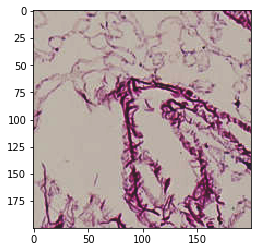

In [25]:
imgout = rescaler.rescale_intensity(img0)
plt.imshow(imgout[:200, :200, :])
type(imgout)
imgout.dtype

In [26]:
img.dtype == np.uint8

True

## Setup rescaler

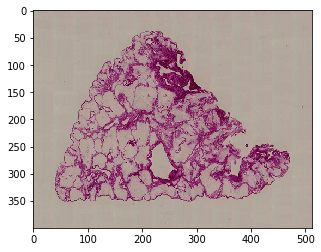

In [27]:
rescaler = RescaleIntensityPercentile()
rescaler.calculate_parameters(img)
img_rescaled = rescaler.rescale_intensity(img)
plt.imshow(img_rescaled)

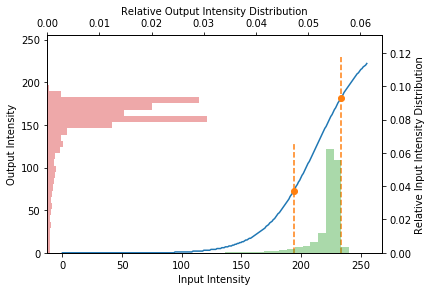

In [36]:
import seaborn as sns
x = np.linspace(0, 255, 255) 
current_palette = sns.color_palette()

y = rescaler.rescale_intensity(x)
fig, ax = plt.subplots()
# ax = plt.figure()
# ax.axis('equal')

cmap = plt.get_cmap()

ax0 = ax.twinx()
ax0.set_ylabel("Relative Input Intensity Distribution")
# plt.hist(img.ravel(), normed=True, cumulative=False, bins=20,)
sns.distplot(img.ravel(), bins=30, kde=False, norm_hist=True, axlabel="Distribution", label="Dist", color=current_palette[2])
lm = ax0.get_ylim()
ax0.set_ylim([lm[0], lm[1] * 2])

ax1 = ax.twiny()
ax1.set_xlabel("Relative Output Intensity Distribution")
sns.distplot(img_rescaled.ravel(), bins=30, kde=False, norm_hist=True, axlabel="Distribution", 
             label="Dist", vertical=True, ax=ax1, color=current_palette[3])
lm = ax1.get_xlim()
ax1.set_xlim([lm[0], lm[1] * 2])

ax.plot()
ax.plot(x, y, color=current_palette[0])
ax.set_xlabel("Input Intensity")
ax.set_ylabel("Output Intensity")
ax.set_ylim([0, 255])

y_prv = rescaler.rescale_intensity(rescaler.percentile_range_values)
y_prv
ax.plot(rescaler.percentile_range_values, y_prv, "o", color=current_palette[1])
# ax.
rescaler.input_dtype

ax.axvline(rescaler.percentile_range_values[0], linestyle="--", ymax=0.5, color=current_palette[1])
ax.axvline(rescaler.percentile_range_values[1], linestyle="--", ymax=0.9, color=current_palette[1])
# plt.savefig("../graphics/intensity_normalization_5p.png", dpi=400, bbox_inches='tight')
# plt.savefig("../graphics/intensity_normalization_5p.pdf", dpi=400, bbox_inches='tight')
# plt.savefig("../graphics/intensity_normalization_5p.eps", dpi=400, bbox_inches='tight')

In [29]:
# plt.imsave("../graphics/intensity_normalization_input.png", img)
# plt.imsave("../graphics/intensity_normalization_output.png", img_rescaled)
